8장 서포트 벡터 머신

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()
#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

df_median = []
df = []

df_median = data_ml[['date', 'R1M_Usd', 'R12M_Usd']].groupby(
    ['date']).median()
df_median.rename(
    columns={"R1M_Usd": "R1M_Usd_median",
             "R12M_Usd": "R12M_Usd_median"}, inplace=True)

df = pd.merge(data_ml, df_median, how='left', on=['date'])

data_ml['R1M_Usd_C'] = np.where(
    df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where(
    df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)

separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()
training_sample = data_ml[data_ml.index.isin(idx_train)]
testing_sample = data_ml[data_ml.index.isin(idx_test)]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_38136\1726175837.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C'] = np.where(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_38136\1726175837.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C'] = np.where(


In [10]:
import xgboost as xgb
data_ml.loc[:, 'R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(
    lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)
)
separation_mask = data_ml['date'] < separation_date

# 행 선택을 위한 불리언 배열
boolean_quantile = (
    (data_ml.loc[separation_mask, 'R1M_Usd_quantile']<=20)|
    (data_ml.loc[separation_mask, 'R1M_Usd_quantile']>=80)
)
# 극단치 선택
train_features_xgb = training_sample.loc[boolean_quantile, features_short]
train_label_xgb = training_sample.loc[boolean_quantile, 'R1M_Usd']
#train_features_xgb = train_features_xgb.to_numpy()
#train_label_xgb = train_label_xgb.to_numpy()
train_label_xgb_C = training_sample.loc[boolean_quantile, 'R1M_Usd_C']



C:\Users\Administrator\AppData\Local\Temp\ipykernel_38136\602288476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.loc[:, 'R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(


In [11]:
from sklearn import svm

y = train_label_xgb.iloc[0:1000]
x = train_features_xgb.iloc[0:1000,]
test_feat_short = testing_sample[features_short]
y_c = train_label_xgb_C.iloc[0:1000]


#train_features_xgb = train_features_xgb.to_numpy()
#train_label_xgb = train_label_xgb.to_numpy()
#train_label_xgb_C = train_label_xgb_C.to_numpy()
y_test = testing_sample['R1M_Usd'].values

model_svm = svm.SVR(
    kernel='rbf',
    C=0.1,
    epsilon=0.1,
    gamma=0.5
)
fit_svm = model_svm.fit(x,y)
mse= np.mean((fit_svm.predict(test_feat_short) - y_test) ** 2)
print(f'MSE: {mse}')

MSE: 0.0372623216226881


In [12]:
hitratio = np.mean(fit_svm.predict(test_feat_short)*y_test>0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5088736326344576


In [15]:
model_svm_c = svm.SVC(
    kernel='sigmoid',
    C=0.2,
    gamma=0.5,
    coef0=0.3
)

y_c_test = testing_sample['R1M_Usd_C'].values

fit_svm_c = model_svm_c.fit(x,y_c)

hitratio = np.mean(fit_svm_c.predict(test_feat_short)==y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.4851014129443938


8.4 코딩 예제

1. 위에 나온 간단한 예제에서 SVM 모델을 다른 커널로 확장하고 적합도에 미치는 영향을 논의하라.

In [16]:
y = train_label_xgb.iloc[1:1000]
x = train_features_xgb.iloc[1:1000,]
test_feat_short = testing_sample[features_short]

def svm_func(_kernel, _C, _gamma, _coef0):
    model_svm = svm.SVR(kernel=_kernel, C=_C, gamma=_gamma, coef0=_coef0)
    fit_svm = model_svm.fit(x,y)
    mse = np.mean((fit_svm.predict(test_feat_short) - y_test) ** 2)
    print(f'MSE: {mse}')
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for i in range(0, len(kernels)):
    svm_func(kernels[i], 0.2, 0.5, 0.3)

MSE: 0.03725673672234242
MSE: 0.0374956596428182
MSE: 0.03879169227180665
MSE: 0.5036757335432294


In [ ]:
#sigmoid 함수의 경우 , 모델 성능이 저하됨.

2. 12개월 선행(즉, 미래) 수익률로 레이블을 지정해 바닐라 SVM 모델을 훈련하고 테스트 샘플에 대해 평가하라. 간단한 랜덤 포레스트에 대해서도 동일한 작업을 수행하고 비교하라.

In [17]:
y = train_label_xgb.iloc[1:50000]
x = train_features_xgb.iloc[1:50000,]
test_feat_short = testing_sample[features_short]

model_svm_full = svm.SVR(
    kernel='linear',
    C=0.1,
    epsilon=0.1,
    gamma=0.5
)
fit_svm_full=model_svm_full.fit(x,y)

hitratio = np.mean(fit_svm_full.predict(test_feat_short)*y_test>0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5300250683682771


비교용 간단한 랜덤포레스트

In [19]:
train_matrix_xgb = xgb.DMatrix(x, label=y)
params={'eta' : 0.3,
        'objective' : "reg:squarederror",
        'max_depth' : 4}
fit_xgb_full = xgb.train(params, train_matrix_xgb, num_boost_round=60)
test_features_xgb = testing_sample[features_short]
test_matrix_xgb = xgb.DMatrix(test_features_xgb, label=y_test)

In [20]:
hitratio = np.mean(fit_xgb_full.predict(test_matrix_xgb) * y_test >0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5236012989972653


9장 베이지안 기법

나이브 베이즈 분류도구

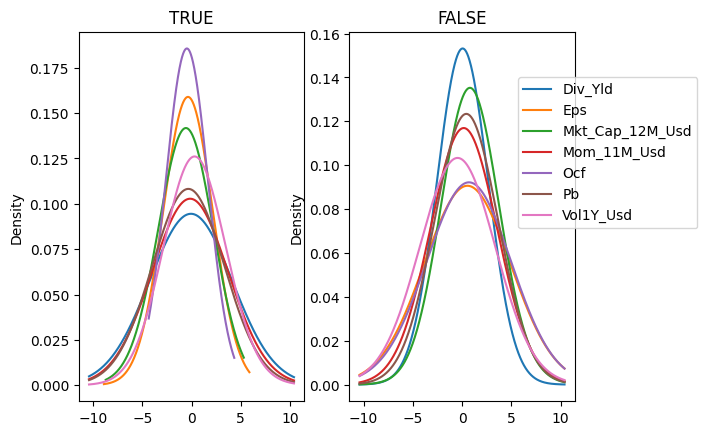

<Figure size 1200x600 with 0 Axes>

In [4]:
y_c_train = training_sample['R1M_Usd_C'].values
y_c_test = testing_sample['R1M_Usd_C'].values

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import QuantileTransformer

quantile = QuantileTransformer(output_distribution='normal')
gauss_features_train = quantile.fit_transform(
    training_sample[features_short]* 0.999 + 0.0001)
gauss_features_test = quantile.fit_transform(
    testing_sample[features_short]*0.999 + 0.001)

fit_NB_guess = GaussianNB()
fit_NB_guess.fit(gauss_features_train, y_c_train)
data_GNB = pd.DataFrame(fit_NB_guess.predict(
    gauss_features_test), columns=['proba'])
data_GNB_cond = pd.concat([data_GNB, pd.DataFrame(
    gauss_features_test, columns=features_short)], axis=1)
df_TRUE = data_GNB_cond.loc[data_GNB_cond['proba']==1, features_short]
df_FALSE = data_GNB_cond.loc[data_GNB_cond['proba']==0, features_short]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df_TRUE.plot.kde(bw_method=3, title='TRUE', ax=ax1, legend=False)
df_FALSE.plot.kde(bw_method=3, title='FALSE', ax=ax2, legend=False)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.8,0.8))
plt.figure(figsize=(12,6))
plt.show()

In [5]:
hitratio = np.mean(fit_NB_guess.predict(
    gauss_features_test)==testing_sample['R1M_Usd_C'].values)
print(f'Hit ratio: {hitratio}')

Hit ratio: 0.49572698268003645


베이지안 가법 트리

In [7]:
import xbart
fit_bart = xbart.XBART(
    num_trees = 20, #모델 내 트리 개수
    num_sweeps = 300, #추출된 사후 값 개수
    burnin = 100, #변인 샘플 크기
    alpha = 0.95, #사전 트리 구조에서의 알파
    beta = 2.0 #사전 트리구조에서의 베타
)

# X와 y를 분리
X = training_sample[features_short].values  # 독립 변수
y = training_sample["R1M_Usd"].values  # 종속 변수

# 모델 학습
fit_bart.fit(X, y)

XBART(num_trees = 20, num_sweeps = 300, n_min = 1, num_cutpoints = 100, alpha = 0.95, beta = 2.0, tau = 0.05, burnin = 100, mtry = 7, max_depth_num = 250, kap = 16.0, s = 4.0, verbose = False, parallel = False, seed = 0, model_num = 0, no_split_penality = 4.605170185988092, sample_weights_flag = True, num_classes = 1)

In [12]:
hitratio = np.mean(fit_bart.predict(
    testing_sample[features_short] )* y_test > 0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5435990200546946


<Axes: xlabel='Simulation', ylabel='Sigma'>

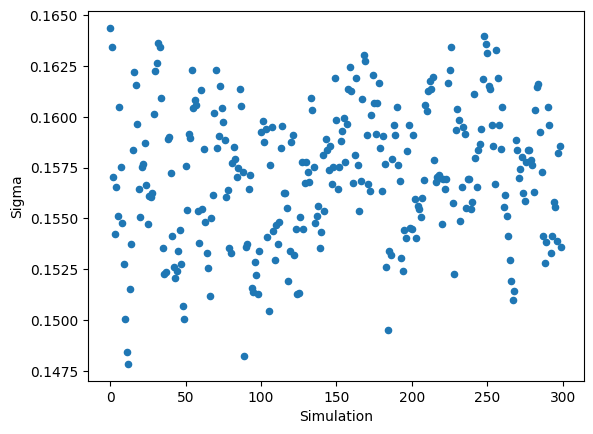

In [15]:
sigma_df = pd.DataFrame(fit_bart.sigma_draws)
sigma_df = sigma_df.mean(axis=1).reset_index()
sigma_df.rename(columns={"index":"Simulation",0:"Sigma"}, inplace=True)
sigma_df.plot.scatter(x='Simulation',y="Sigma")